# Dependencies

In [1]:
pacman::p_load(dplyr, ggplot2, pBrackets, ggpubr, cowplot,readxl)

# Functions

In [3]:
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/color_schemes.R")

# Paths

In [4]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [5]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Files

In [73]:
meta_div <- readr::read_rds(file = paste0(datapath,"capTCRseq/meta_div_goodsamples.rds"))

In [74]:
# Save the cleaned soc_good dataframe as RDS
soc_good <- readRDS(file = file.path(datapath, "chemo_cycles_cleaned.rds"))

In [75]:
head(soc_good)

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Drugs,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Drugs,Cycle 2 Duration (days),Cycle 2 Steroids,...,Cycle 4 Type,Cycle 4 Drugs,Cycle 4 Duration (days),Cycle 4 Steroids,Cycle 5 Type,Cycle 5 Drugs,Cycle 5 Duration (days),Cycle 5 Steroids,Disease,Cancergroup
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
319,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",63,Yes,Interim Maintenance II,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",84,Yes,HR ALL,Leukemia
323,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",63,Yes,Interim Maintenance II,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",84,Yes,HR ALL,Leukemia
324,T-ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Asparaginase, Mercaptopurine, Cyclophosphamide, Cyatarabine",56,no,...,Delayed Intensification,"Vincristine, Asparaginase, Doxorubicin, Dexamethasone, Cyclophosphamide, Cytarabine, Thioguanine",63,yes,N/A,N/A,N/A,N/A,T-ALL,T-cell malignancies
326,SR ALL,Induction,"Vincristine, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Mercaptopurine",28,no,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",56,yes,Interim Maintenance II,"Vincristine, Dexamethasone, Mercaptopurine, Methotrexate *repeats until end of therapy",56,yes,SR ALL,Leukemia
328,SR ALL,Induction,"Vincristine, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Mercaptopurine",28,no,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",56,yes,Interim Maintenance II,"Vincristine, Dexamethasone, Mercaptopurine, Methotrexate *repeats until end of therapy",56,yes,SR ALL,Leukemia
329,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",63,Yes,Interim Maintenance II,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",84,Yes,HR ALL,Leukemia


# Main

## Bubble plot

In [76]:
# Reshape soc_good to long format for all drug columns
soc_good_long <- soc_good %>%
  tidyr::pivot_longer(
    cols = matches("Cycle \\d+ Drugs"),
    names_to = "cycle",
    values_to = "drugs",
    names_pattern = "Cycle (\\d+) Drugs"
  ) %>%
  # Keep all other columns
  select(everything()) %>%
  # Clean up cycle numbers
  mutate(cycle = as.numeric(cycle))


In [77]:
soc_good_long_sep <- soc_good_long %>%
  tidyr::separate_rows(drugs, sep = ",\\s*") 

In [78]:
# Remove anything after asterisk in drugs column
soc_good_long_sep$drugs <- sub("\\*.*$", "", soc_good_long_sep$drugs)
# Remove "held during radiation" from drugs column
soc_good_long_sep$drugs <- sub("held during radiation", "", soc_good_long_sep$drugs)
soc_good_long_sep$drugs <- trimws(soc_good_long_sep$drugs) # Remove any trailing whitespace


In [79]:
# Fix inconsistent drug spellings
soc_good_long_sep$drugs <- gsub("dactinomycin", "Dactinomycin", soc_good_long_sep$drugs, ignore.case=TRUE)
soc_good_long_sep$drugs <- gsub("Cisplatinum", "Cisplatin", soc_good_long_sep$drugs, ignore.case=TRUE) 
soc_good_long_sep$drugs <- gsub("Cyatarabine", "Cytarabine", soc_good_long_sep$drugs, ignore.case=TRUE)


In [80]:
soc_good_long_sep$drug_type <- NA
soc_good_long_sep$drug_type[grepl("Vincristine|Daunorubicin|Asparaginase|Mercaptopurine|Cyclophosphamide|Cytarabine|Methotrexate|Doxorubicin|Thioguanine|Cisplatin|Bleomyocin|Etoposide|5-Fluorouracil|Mitoxantrone|Ifosphamide|Topotecan|Dactinomycin", soc_good_long_sep$drugs, ignore.case=TRUE)] <- "Chemotherapy"
soc_good_long_sep$drug_type[grepl("Dexamethasone|Prednisone", soc_good_long_sep$drugs, ignore.case=TRUE)] <- "Steroid"
soc_good_long_sep$drug_type[grepl("Imatinib", soc_good_long_sep$drugs, ignore.case=TRUE)] <- "Small molecule"

In [81]:
head(soc_good_long_sep)

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Duration (days),Cycle 2 Steroids,Cycle 3 Type,Cycle 3 Duration (days),...,Cycle 4 Duration (days),Cycle 4 Steroids,Cycle 5 Type,Cycle 5 Duration (days),Cycle 5 Steroids,Disease,Cancergroup,cycle,drugs,drug_type
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
319,HR ALL,Induction,35,Yes,Consolidation,56,No,Interim Maintenance I,63,...,63,Yes,Interim Maintenance II,84,Yes,HR ALL,Leukemia,1,Vincristine,Chemotherapy
319,HR ALL,Induction,35,Yes,Consolidation,56,No,Interim Maintenance I,63,...,63,Yes,Interim Maintenance II,84,Yes,HR ALL,Leukemia,1,Daunorubicin,Chemotherapy
319,HR ALL,Induction,35,Yes,Consolidation,56,No,Interim Maintenance I,63,...,63,Yes,Interim Maintenance II,84,Yes,HR ALL,Leukemia,1,Asparaginase,Chemotherapy
319,HR ALL,Induction,35,Yes,Consolidation,56,No,Interim Maintenance I,63,...,63,Yes,Interim Maintenance II,84,Yes,HR ALL,Leukemia,1,Dexamethasone,Steroid
319,HR ALL,Induction,35,Yes,Consolidation,56,No,Interim Maintenance I,63,...,63,Yes,Interim Maintenance II,84,Yes,HR ALL,Leukemia,2,Vincristine,Chemotherapy
319,HR ALL,Induction,35,Yes,Consolidation,56,No,Interim Maintenance I,63,...,63,Yes,Interim Maintenance II,84,Yes,HR ALL,Leukemia,2,Mercaptopurine,Chemotherapy


In [15]:
# # Clean up drug names and recreate tab
# tab <- soc_good %>%
# tidyr::separate_rows(`Cycle 1 Drugs`, sep = ",\\s*") %>%
# mutate(`Cycle 1 Drugs` = trimws(`Cycle 1 Drugs`)) %>%
# filter(!is.na(`Cycle 1 Drugs`), `Cycle 1 Drugs` != "") %>%
# mutate(`Cycle 1 Drugs` = case_when(
#   grepl("dactinomycin held during radiation", `Cycle 1 Drugs`, ignore.case = TRUE) ~ "Dactinomycin",
#   grepl("Cyclophosphamide.*Repeated every three weeks", `Cycle 1 Drugs`, ignore.case = TRUE) ~ "Cyclophosphamide",
#   TRUE ~ `Cycle 1 Drugs`
# )) %>%
# group_by(Disease, Cancergroup, `Cycle 1 Drugs`) %>% 
# summarise(Count = n(), .groups = "drop")


In [16]:
# # Function to create drug analysis and visualization for any cycle
# create_drug_analysis <- function(alldata, cycle_name = "1") {
#   data <- alldata[alldata$cycle == cycle_name, ]
#   data <- data[ which(data$drugs != "N/A"), ]
#   data <- data[ !is.na(data$drugs), ]
#   # Clean up drug names and create tab
#   tab <- data %>%
#     group_by(Disease, Cancergroup, drugs) %>% 
#     summarise(Count = n(), .groups = "drop")
  
#   # Add drug_type column by matching drugs from data
#   drug_type_mapping <- data %>%
#     select(drugs, drug_type) %>%
#     distinct()
  
#   tab <- tab %>%
#     left_join(drug_type_mapping, by = c("drugs" = "drugs"))
# #   # Add drug_type column
# #   tab <- tab %>%
# #     left_join(data %>% select(drugs, drug_type), by = "drugs")
  
#   # Arrange and factorize
#   tab <- tab %>%
#     arrange(Cancergroup, Disease, Count) %>%
#     mutate(Disease = factor(Disease, levels = unique(Disease)))

#   # Create drug_type_summary for faceting order
#   drug_type_summary <- tab %>%
#     group_by(drug_type) %>%
#     summarise(total_count = sum(Count)) %>%
#     arrange(desc(total_count))
  
#   # Factorize drugs based on total count within each drug type
#   tab <- tab %>%
#     group_by(drugs, drug_type) %>%
#     mutate(total_count = sum(Count)) %>%
#     arrange(total_count) %>%
#     #mutate(drugs = factor(drugs, levels = unique(drugs))) %>%
#     ungroup()
#     tab$drugs <- factor(tab$drugs, levels = unique(tab$drugs))
  
#   # Create the plot
#   p <- ggplot(tab, aes(x = Disease, y = drugs, size = Count, color = Cancergroup)) + 
#     geom_point(alpha = 0.6) + 
#     scale_size(range = c(3,12)) +
#     scale_color_manual(values = group_col) +
#     theme_minimal() + 
#     theme(axis.text.x = element_text(angle = 30, hjust = 1),
#           axis.title = element_blank()) +
#     labs(title = paste("Drug Usage by Disease at cycle", cycle_name))
  
#   # Add facets
#   p <- p + facet_grid(vars(drug_type), scales = "free_y", space = "free", switch = "y") +
#     theme(strip.text.y.left = element_text(angle = 0), strip.placement = "outside")
  
#   return(list(tab = tab, plot = p, summary = drug_type_summary))
# }


In [17]:
# cycle1_results <- create_drug_analysis(soc_good_long_sep, "1")
# cycle2_results <- create_drug_analysis(soc_good_long_sep, "2")
# cycle3_results <- create_drug_analysis(soc_good_long_sep, "3")


In [18]:
  dt <- soc_good_long_sep[ which(soc_good_long_sep$drugs != "N/A"), ]
  dt <- dt[ !is.na(dt$drugs), ]

In [19]:
(unique(dt$drugs))

[1] "Vincristine"      "Daunorubicin"     "Asparaginase"     "Dexamethasone"   
 [5] "Mercaptopurine"   "Cyclophosphamide" "Cytarabine"       "Methotrexate"    
 [9] "Doxorubicin"      "Thioguanine"      "Prednisone"       "Cisplatin"       
[13] "Dactinomycin"     "Bleomyocin"       "Etoposide"        "5-Fluorouracil"  
[17] "Mitoxantrone"     "Imatinib"         "Ifosphamide"      "Topotecan"

In [20]:
dim(dt)

[1] 1667   22

In [21]:
  tab <- dt %>%
    group_by(Disease, Cancergroup, cycle, drugs) %>% 
    summarise(Count = n(), .groups = "drop")
  
  # Add drug_type column by matching drugs from data
  drug_type_mapping <- dt %>%
    select(drugs, drug_type) %>%
    distinct()
  
  tab <- tab %>%
    left_join(drug_type_mapping, by = c("drugs" = "drugs"))

In [22]:
  tab <- tab %>%
    arrange(Cancergroup, Disease, Count) %>%
    mutate(Disease = factor(Disease, levels = unique(Disease)))

  # Create drug_type_summary for faceting order
  drug_type_summary <- tab %>%
    group_by(drug_type) %>%
    summarise(total_count = sum(Count)) %>%
    arrange(desc(total_count))
  
  # Factorize drugs based on total count within each drug type
  tab <- tab %>%
    group_by(drugs, drug_type) %>%
    mutate(total_count = sum(Count)) %>%
    arrange(total_count) %>%
    #mutate(drugs = factor(drugs, levels = unique(drugs))) %>%
    ungroup()
    tab$drugs <- factor(tab$drugs, levels = unique(tab$drugs))

In [23]:
tab$cycle <- paste0("Cycle ", tab$cycle)

In [24]:
tab$cycle <- factor(tab$cycle, levels = c("Cycle 1", "Cycle 2", "Cycle 3", "Cycle 4", "Cycle 5"))

In [25]:
sum(tab$Count)

[1] 1667

In [26]:
tab$perc <- tab$total_count/sum(tab$Count)

In [27]:
tab[order(tab$total_count, decreasing = TRUE), ] # convert to gtsummary 

Disease,Cancergroup,cycle,drugs,Count,drug_type,total_count,perc
<fct>,<chr>,<fct>,<fct>,<int>,<chr>,<int>,<dbl>
ALL,Leukemia,Cycle 1,Vincristine,23,Chemotherapy,317,0.190162
ALL,Leukemia,Cycle 2,Vincristine,23,Chemotherapy,317,0.190162
ALL,Leukemia,Cycle 3,Vincristine,23,Chemotherapy,317,0.190162
ALL,Leukemia,Cycle 4,Vincristine,23,Chemotherapy,317,0.190162
ALL,Leukemia,Cycle 5,Vincristine,23,Chemotherapy,317,0.190162
HR ALL,Leukemia,Cycle 1,Vincristine,14,Chemotherapy,317,0.190162
HR ALL,Leukemia,Cycle 2,Vincristine,14,Chemotherapy,317,0.190162
HR ALL,Leukemia,Cycle 3,Vincristine,14,Chemotherapy,317,0.190162
HR ALL,Leukemia,Cycle 4,Vincristine,14,Chemotherapy,317,0.190162


In [21]:
p <- ggplot(tab, aes(x = Disease, y = drugs, size = Count, color = Cancergroup)) + 
    geom_point(alpha = 0.6, shape = 16) + 
    scale_size(range = c(1,6)) +
    scale_color_manual(values = group_col) +
    theme_minimal() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6),
          axis.title = element_blank(),
          plot.margin = margin(t = 20, r = 20, b = 20, l = 20, unit = "pt")) +
    coord_cartesian(clip = "off") +
    labs(title = paste("Drug Usage by Disease"))
  
  # Add facets
  p <- p + facet_grid(vars(drug_type), vars(cycle), scales = "free_y", space = "free", switch = "y") +
    theme(strip.text.y.left = element_text(angle = 0), strip.placement = "outside")

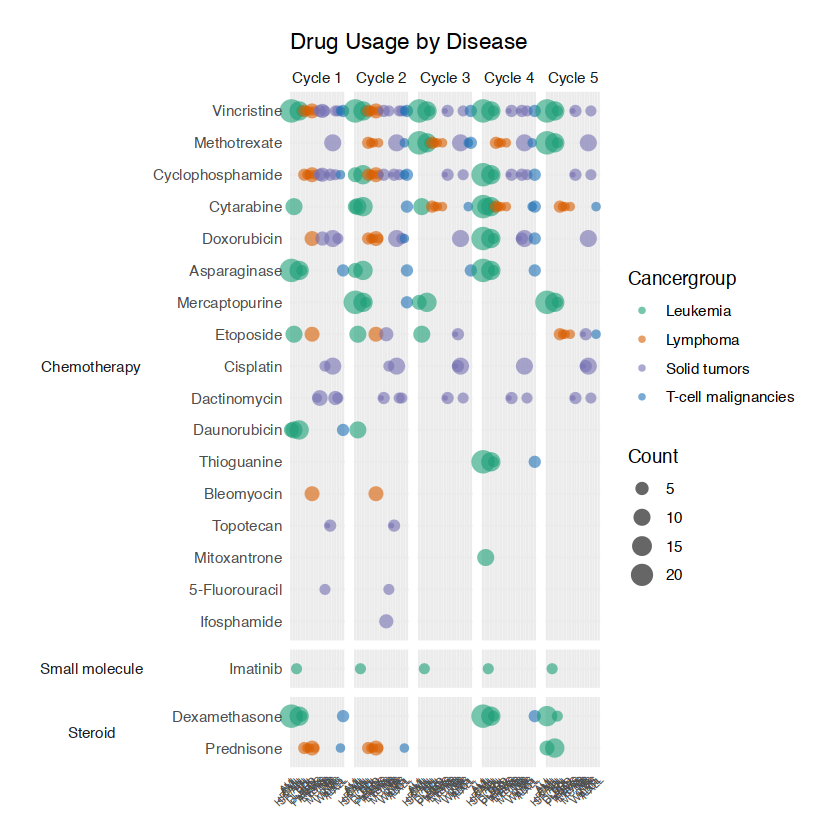

In [22]:
p

In [23]:
ggsave(paste0(plotpath, "drug_usage_by_disease.pdf"), p, width = 15, height = 6)
ggsave(paste0(plotpath, "drug_usage_by_disease.png"), p, width = 15, height = 6)

In [24]:
# # Function to create drug analysis and visualization for any cycle
# create_drug_analysis <- function(alldata, cycle_name = "1") {
#   data <- alldata[alldata$cycle == cycle_name, ]
#   data <- data[ which(data$drugs != "N/A"), ]
#   data <- data[ !is.na(data$drugs), ]
#   # Clean up drug names and create tab
#   tab <- data %>%
#     group_by(Disease, Cancergroup, drugs) %>% 
#     summarise(Count = n(), .groups = "drop")
  
#   # Add drug_type column by matching drugs from data
#   drug_type_mapping <- data %>%
#     select(drugs, drug_type) %>%
#     distinct()
  
#   tab <- tab %>%
#     left_join(drug_type_mapping, by = c("drugs" = "drugs"))
# #   # Add drug_type column
# #   tab <- tab %>%
# #     left_join(data %>% select(drugs, drug_type), by = "drugs")
  
#   # Arrange and factorize
#   tab <- tab %>%
#     arrange(Cancergroup, Disease, Count) %>%
#     mutate(Disease = factor(Disease, levels = unique(Disease)))

#   # Create drug_type_summary for faceting order
#   drug_type_summary <- tab %>%
#     group_by(drug_type) %>%
#     summarise(total_count = sum(Count)) %>%
#     arrange(desc(total_count))
  
#   # Factorize drugs based on total count within each drug type
#   tab <- tab %>%
#     group_by(drugs, drug_type) %>%
#     mutate(total_count = sum(Count)) %>%
#     arrange(total_count) %>%
#     #mutate(drugs = factor(drugs, levels = unique(drugs))) %>%
#     ungroup()
#     tab$drugs <- factor(tab$drugs, levels = unique(tab$drugs))
  
#   # Create the plot
#   p <- ggplot(tab, aes(x = Disease, y = drugs, size = Count, color = Cancergroup)) + 
#     geom_point(alpha = 0.6) + 
#     scale_size(range = c(3,12)) +
#     scale_color_manual(values = group_col) +
#     theme_minimal() + 
#     theme(axis.text.x = element_text(angle = 30, hjust = 1),
#           axis.title = element_blank()) +
#     labs(title = paste("Drug Usage by Disease at cycle", cycle_name))
  
#   # Add facets
#   p <- p + facet_grid(vars(drug_type), scales = "free_y", space = "free", switch = "y") +
#     theme(strip.text.y.left = element_text(angle = 0), strip.placement = "outside")
  
#   return(list(tab = tab, plot = p, summary = drug_type_summary))
# }


In [25]:
# p <- ggplot(tab, aes(x = Disease, y = `Cycle 1 Drugs`, size = Count, color = Cancergroup)) + 
# geom_point(alpha = 0.6) + scale_size(range = c(3,12)) +
# scale_color_manual(values = group_col) +
# theme_minimal() + 
# theme(axis.text.x = element_text(angle = 30, hjust = 1),
# axis.title = element_blank()) 
# p <- p + facet_grid(vars(drug_type), scales = "free_y", space = "free", switch = "y") +
#   theme(strip.text.y.left = element_text(angle = 0), strip.placement = "outside") 



In [26]:
# pdf(paste0(plotpath, "bubbleplot_cycle1cancer_drugs.pdf"), width = 15, height = 8)
# p
# dev.off()

# Swimmerplot

In [28]:
head(soc_good)

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Drugs,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Drugs,Cycle 2 Duration (days),Cycle 2 Steroids,...,Cycle 4 Type,Cycle 4 Drugs,Cycle 4 Duration (days),Cycle 4 Steroids,Cycle 5 Type,Cycle 5 Drugs,Cycle 5 Duration (days),Cycle 5 Steroids,Disease,Cancergroup
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
319,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",63,Yes,Interim Maintenance II,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",84,Yes,HR ALL,Leukemia
323,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",63,Yes,Interim Maintenance II,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",84,Yes,HR ALL,Leukemia
324,T-ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Asparaginase, Mercaptopurine, Cyclophosphamide, Cyatarabine",56,no,...,Delayed Intensification,"Vincristine, Asparaginase, Doxorubicin, Dexamethasone, Cyclophosphamide, Cytarabine, Thioguanine",63,yes,N/A,N/A,N/A,N/A,T-ALL,T-cell malignancies
326,SR ALL,Induction,"Vincristine, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Mercaptopurine",28,no,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",56,yes,Interim Maintenance II,"Vincristine, Dexamethasone, Mercaptopurine, Methotrexate *repeats until end of therapy",56,yes,SR ALL,Leukemia
328,SR ALL,Induction,"Vincristine, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Mercaptopurine",28,no,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",56,yes,Interim Maintenance II,"Vincristine, Dexamethasone, Mercaptopurine, Methotrexate *repeats until end of therapy",56,yes,SR ALL,Leukemia
329,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Delayed Intensification,"Vincristine, Doxorubicin, Dexamethasone, Asparaginase, Cyclophosphamide, Thioguanine, Cytarabine",63,Yes,Interim Maintenance II,"Vincristine, Prednisone, Mercaptopurine, Methotrexate *repeats until end of therapy",84,Yes,HR ALL,Leukemia


In [31]:
soc_good_long_sep[ soc_good_long_sep$`Patient ID` == "350",]

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Duration (days),Cycle 2 Steroids,Cycle 3 Type,Cycle 3 Duration (days),...,Cycle 4 Duration (days),Cycle 4 Steroids,Cycle 5 Type,Cycle 5 Duration (days),Cycle 5 Steroids,Disease,Cancergroup,cycle,drugs,drug_type
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,1,Cisplatin,Chemotherapy
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,1,5-Fluorouracil,Chemotherapy
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,1,Vincristine,Chemotherapy
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,2,Cisplatin,Chemotherapy
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,2,5-Fluorouracil,Chemotherapy
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,2,Vincristine,Chemotherapy
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,3,N/A,NA
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,4,N/A,NA
350,Hepatoblastoma,Cycle 1,21,No,Cycle 2,21,No,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,HB,Solid tumors,5,N/A,NA


In [32]:
# Create base_regimen columns for each cycle
soc_good$base_regimen_cycle1 <- NA
soc_good$base_regimen_cycle2 <- NA 
soc_good$base_regimen_cycle3 <- NA
soc_good$base_regimen_cycle4 <- NA
soc_good$base_regimen_cycle5 <- NA

# Process each cycle separately
for(cycle in 1:5) {
  # Filter for current cycle
  cycle_data <- soc_good_long_sep[soc_good_long_sep$cycle == cycle,]
  
  # Get unique patients with specific drugs in this cycle
  vin_patients <- unique(cycle_data$`Patient ID`[cycle_data$drugs == "Vincristine"])
  mtx_patients <- unique(cycle_data$`Patient ID`[cycle_data$drugs == "Methotrexate"])
  cyclo_patients <- unique(cycle_data$`Patient ID`[cycle_data$drugs == "Cyclophosphamide"])
  norx_patients <- unique(cycle_data$`Patient ID`[cycle_data$drugs == "N/A"])
  # Assign regimens for this cycle
  col_name <- paste0("base_regimen_cycle", cycle)
  soc_good[[col_name]] <- sapply(soc_good$`Patient ID`, function(pat) {
    regimens <- c()
    if(pat %in% vin_patients) regimens <- c(regimens, "Vincristine")
    if(pat %in% mtx_patients) regimens <- c(regimens, "Methotrexate") 
    if(pat %in% cyclo_patients) regimens <- c(regimens, "Cyclophosphamide")
    if(pat %in% norx_patients) regimens <- c(regimens, "No therapy")
    if(length(regimens) == 0) return(NA)
    paste(regimens, collapse = "/")
  })
  
  # Fill NAs with "Others"
  soc_good[[col_name]][is.na(soc_good[[col_name]])] <- "Others"
}

In [34]:
# Reorder base regimen factors to put "Others" at the end
regimen_levels <- c("Vincristine", "Methotrexate", "Cyclophosphamide", 
                   "Vincristine/Methotrexate", "Vincristine/Cyclophosphamide",
                   "Vincristine/Methotrexate/Cyclophosphamide",
                   "Others", "No therapy")

soc_good$base_regimen_cycle1 <- factor(soc_good$base_regimen_cycle1, levels=regimen_levels)
soc_good$base_regimen_cycle2 <- factor(soc_good$base_regimen_cycle2, levels=regimen_levels) 
soc_good$base_regimen_cycle3 <- factor(soc_good$base_regimen_cycle3, levels=regimen_levels)
soc_good$base_regimen_cycle4 <- factor(soc_good$base_regimen_cycle4, levels=regimen_levels)
soc_good$base_regimen_cycle5 <- factor(soc_good$base_regimen_cycle5, levels=regimen_levels)


In [35]:
# Combine all base_regimen_cycle columns into a single vector
all_regimens <- c(
  as.character(soc_good$base_regimen_cycle1),
  as.character(soc_good$base_regimen_cycle2),
  as.character(soc_good$base_regimen_cycle3),
  as.character(soc_good$base_regimen_cycle4),
  as.character(soc_good$base_regimen_cycle5)
)

# Create a table of counts
regimen_counts <- table(all_regimens, useNA = "ifany")

# Calculate total count (excluding NA)
total_count <- sum(regimen_counts[!is.na(names(regimen_counts))])

# Calculate percentages
percent <- (as.numeric(regimen_counts) / total_count) * 100

# Make dataframe
regimen_summary <- data.frame(
  Regimen = names(regimen_counts),
  Count = as.numeric(regimen_counts),
  Percentage = round(percent, 2)
)

# Add the total as a new column (same value for all rows)
regimen_summary$Total = total_count

regimen_summary # convert to gtsummary 

Regimen,Count,Percentage,Total
<chr>,<dbl>,<dbl>,<int>
Cyclophosphamide,10,1.80,555
Methotrexate,74,13.33,555
No therapy,53,9.55,555
Others,101,18.20,555
Vincristine,75,13.51,555
Vincristine/Cyclophosphamide,146,26.31,555
Vincristine/Methotrexate,84,15.14,555
Vincristine/Methotrexate/Cyclophosphamide,12,2.16,555


In [36]:
# Create cycle existence columns
soc_good$cycle1exist <- ifelse(soc_good$`Cycle 1 Duration (days)` %in% c("N/A", NA), NA, "Yes")
soc_good$cycle2exist <- ifelse(soc_good$`Cycle 2 Duration (days)` %in% c("N/A", NA), NA, "Yes") 
soc_good$cycle3exist <- ifelse(soc_good$`Cycle 3 Duration (days)` %in% c("N/A", NA), NA, "Yes")
soc_good$cycle4exist <- ifelse(soc_good$`Cycle 4 Duration (days)` %in% c("N/A", NA), NA, "Yes")
soc_good$cycle5exist <- ifelse(soc_good$`Cycle 5 Duration (days)` %in% c("N/A", NA), NA, "Yes")


In [37]:
head(soc_good)

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Drugs,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Drugs,Cycle 2 Duration (days),Cycle 2 Steroids,...,base_regimen_cycle1,base_regimen_cycle2,base_regimen_cycle3,base_regimen_cycle4,base_regimen_cycle5,cycle1exist,cycle2exist,cycle3exist,cycle4exist,cycle5exist
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
319,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Vincristine,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Yes,Yes,Yes,Yes,Yes
323,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Vincristine,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Yes,Yes,Yes,Yes,Yes
324,T-ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Asparaginase, Mercaptopurine, Cyclophosphamide, Cyatarabine",56,no,...,Vincristine,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,No therapy,Yes,Yes,Yes,Yes,NA
326,SR ALL,Induction,"Vincristine, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Mercaptopurine",28,no,...,Vincristine,Vincristine,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Yes,Yes,Yes,Yes,Yes
328,SR ALL,Induction,"Vincristine, Asparaginase, Dexamethasone",35,yes,Consolidation,"Vincristine, Mercaptopurine",28,no,...,Vincristine,Vincristine,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Yes,Yes,Yes,Yes,Yes
329,HR ALL,Induction,"Vincristine, Daunorubicin, Asparaginase, Dexamethasone",35,Yes,Consolidation,"Vincristine, Mercaptopurine, Cyclophosphamide, Cytarabine, Asparaginase",56,No,...,Vincristine,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,Yes,Yes,Yes,Yes,Yes


In [38]:
soc_good$Patient <- paste0("CHP_",soc_good$`Patient ID`)

In [ ]:
# readr::write_rds(soc_good, paste0(datapath,"soc_good_with_baseregimen.rds"))

In [40]:
drugs <- soc_good 

In [41]:
dim(drugs)

[1] 111  35

In [42]:
cols.num <- colnames(drugs)[grepl("Duration", colnames(drugs))]
drugs[cols.num] <- sapply(drugs[cols.num],as.numeric)

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


In [43]:
drugs$trtend <- rowSums(drugs[,c("Cycle 1 Duration (days)", "Cycle 2 Duration (days)",
"Cycle 3 Duration (days)", "Cycle 4 Duration (days)", "Cycle 5 Duration (days)")], na.rm = T)

drugs$trtend <- drugs$trtend + 50 # offset for the swimmerplo

In [44]:
# Create a vector of the "Cycle X Duration (days)" column names
cycle_duration_cols <- grep("Cycle [1-5] Duration \\(days\\)", colnames(drugs), value = TRUE)

# Summarize each Cycle X Duration column
cycle_summaries <- lapply(cycle_duration_cols, function(col) {
  cat(paste0("\nSummary for ", col, ":\n"))
  print(summary(drugs[[col]]))
})

# Summarize all Cycle X Duration columns together (stacked)
all_durations <- unlist(drugs[cycle_duration_cols])
cat("\nSummary for all Cycle Duration columns combined:\n")
print(summary(all_durations))


Summary for Cycle 1 Duration (days):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.00   21.00   35.00   35.38   35.00   84.00 

Summary for Cycle 2 Duration (days):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  21.00   21.00   28.00   41.81   56.00  154.00 

Summary for Cycle 3 Duration (days):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  21.00   21.00   35.00   41.85   56.00   63.00      19 

Summary for Cycle 4 Duration (days):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  21.00   21.00   35.00   42.15   63.00   63.00      19 

Summary for Cycle 5 Duration (days):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  21.00   21.00   56.00   48.55   84.00   84.00      33 

Summary for all Cycle Duration columns combined:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   7.00   21.00   35.00   41.49   56.00  154.00      71 


In [45]:
# Factor Patient to respect arrange(Cancergroup, base_regimen_cycle1) with longest cycle 1 duration last
drugs <- drugs %>%
  arrange(Cancergroup, trtend, base_regimen_cycle1) %>%
  mutate(Patient = factor(Patient, levels = unique(Patient)))

In [46]:
summary(drugs$trtend)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   92.0   155.0   260.0   230.9   281.0   351.0 

In [47]:
pacman::p_load(swimplot)

In [48]:
# drugs$Patient <- paste0("CHP_",drugs$`Patient ID`)

In [49]:
drugs <- as.data.frame(drugs)

In [50]:
drugs[ drugs$Patient == "CHP_389",21:30 ]

,Cycle 5 Duration (days),Cycle 5 Steroids,Disease,Cancergroup,base_regimen_cycle1,base_regimen_cycle2,base_regimen_cycle3,base_regimen_cycle4,base_regimen_cycle5,cycle1exist
,<dbl>,<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
58,NA,N/A,HD,Lymphoma,Vincristine/Cyclophosphamide,Vincristine/Cyclophosphamide,No therapy,No therapy,No therapy,Yes


In [51]:
# swim <- swimmer_plot(df = drugs, id="Patient", end="trtend", id_order=drugs$Patient,col = "#cdcaca", name_fill = "Cancergroup", alpha = 0.5, width = 0.8)

In [52]:
# swim

In [62]:
swim <- swimmer_plot(df = drugs, id="Patient", end="trtend", id_order=drugs$Patient,col = "#cdcaca", fill = "#cdcaca", alpha = 0.5, width = 0.6)

In [54]:
drugs$cycle2start <- drugs$`Cycle 1 Duration (days)`
drugs$cycle2start <-drugs$cycle2start + 10
drugs$cycle2end <- rowSums(drugs[,c("cycle2start","Cycle 2 Duration (days)")], na.rm = T)

drugs$cycle3start <- rowSums(drugs[,c("cycle2start","Cycle 2 Duration (days)")], na.rm = T)
drugs$cycle3start <- drugs$cycle3start + 10
drugs$cycle3end <- rowSums(drugs[,c("cycle3start","Cycle 3 Duration (days)")], na.rm = T)

drugs$cycle4start <- rowSums(drugs[,c("cycle3start","Cycle 3 Duration (days)")], na.rm = T)
drugs$cycle4start <- drugs$cycle4start + 10
drugs$cycle4end <- rowSums(drugs[,c("cycle4start","Cycle 4 Duration (days)")], na.rm = T)

drugs$cycle5start <- rowSums(drugs[,c("cycle4start","Cycle 4 Duration (days)")], na.rm = T)
drugs$cycle5start <- drugs$cycle5start + 10
drugs$cycle5end <- rowSums(drugs[,c("cycle5start","Cycle 5 Duration (days)")], na.rm = T)


In [55]:
# Convert cycle starts/ends to NA if Duration is NA or "N/A"
drugs$cycle2start[drugs$`Cycle 2 Duration (days)` %in% c(NA, "N/A")] <- NA
drugs$cycle2end[drugs$`Cycle 2 Duration (days)` %in% c(NA, "N/A")] <- NA

drugs$cycle3start[drugs$`Cycle 3 Duration (days)` %in% c(NA, "N/A")] <- NA 
drugs$cycle3end[drugs$`Cycle 3 Duration (days)` %in% c(NA, "N/A")] <- NA

drugs$cycle4start[drugs$`Cycle 4 Duration (days)` %in% c(NA, "N/A")] <- NA
drugs$cycle4end[drugs$`Cycle 4 Duration (days)` %in% c(NA, "N/A")] <- NA

drugs$cycle5start[drugs$`Cycle 5 Duration (days)` %in% c(NA, "N/A")] <- NA
drugs$cycle5end[drugs$`Cycle 5 Duration (days)` %in% c(NA, "N/A")] <- NA

# Add flags for cycle existence
drugs$cycle2exist <- ifelse(!is.na(drugs$`Cycle 2 Duration (days)`), "Yes", NA)
drugs$cycle3exist <- ifelse(!is.na(drugs$`Cycle 3 Duration (days)`), "Yes", NA) 
drugs$cycle4exist <- ifelse(!is.na(drugs$`Cycle 4 Duration (days)`), "Yes", NA)
drugs$cycle5exist <- ifelse(!is.na(drugs$`Cycle 5 Duration (days)`), "Yes", NA)


In [56]:
table(drugs$cycle4exist, useNA = "always")


 Yes <NA> 
  92   19 

In [63]:
myswim <- swim +
swimmer_points(df_points = drugs, id = "Patient", time = 0, name_col = "cycle1exist", size = 1) +
swimmer_lines(df_lines = drugs, id = "Patient", start = "0", end = "`Cycle 1 Duration (days)`", name_col = "base_regimen_cycle1", size = 0.5) +
swimmer_points(df_points = drugs, id = "Patient", time = "cycle2start", name_col = "cycle2exist", size = 1) +
swimmer_lines(df_lines = drugs, id = "Patient", start = "cycle2start", end = "cycle2end", name_col = "base_regimen_cycle2", size = 0.5) +
swimmer_points(df_points = drugs, id = "Patient", time = "cycle3start", name_col = "cycle3exist", size = 1) +
swimmer_lines(df_lines = drugs, id = "Patient", start = "cycle3start", end = "cycle3end", name_col = "base_regimen_cycle3", size = 0.5) +
swimmer_points(df_points = drugs, id = "Patient", time = "cycle4start", name_col = "cycle4exist", size = 1) +
swimmer_lines(df_lines = drugs, id = "Patient", start = "cycle4start", end = "cycle4end", name_col = "base_regimen_cycle4", size = 0.5) +
swimmer_points(df_points = drugs, id = "Patient", time = "cycle5start", name_col = "cycle5exist", size = 1) +
swimmer_lines(df_lines = drugs, id = "Patient", start = "cycle5start", end = "cycle5end", name_col = "base_regimen_cycle5", size = 0.5) 

In [64]:
pacman::p_load(RColorBrewer)

In [68]:
myp <- myswim + 
scale_color_manual(name = "Regimen", 
values = c("Vincristine" = "#E41A1C", 
           "Methotrexate" = "#377EB8",
           "Cyclophosphamide" = "#4DAF4A",
           "Vincristine/Methotrexate" = "#984EA3",
           "Vincristine/Cyclophosphamide" = "#fa9734",
           "Vincristine/Methotrexate/Cyclophosphamide" = "#f781bf",
           "No therapy" = "grey",
           "Others" = "black",
           "Yes" = "black",
           na.value=NA),
breaks = c("Vincristine", "Methotrexate", "Cyclophosphamide", 
           "Vincristine/Methotrexate", "Vincristine/Cyclophosphamide",
           "Vincristine/Methotrexate/Cyclophosphamide",
           "Others")) +
guides(color = guide_legend(override.aes = list(shape = NA))) +
labs(y = "Days after Cycle 1 therapy start", x = "") 


In [69]:
# myp_ann <- myp 
# geom_bracket(xmin = c(1, 52, 68, 97), xmax = c(51, 67, 96, 102), y.position = c(-22, -22,-22,-22),
#   label.size = 7, label = c("", "", "", ""), coord.flip = T) + # changes the orientaitons of labels, set without label, then add with annotate
#   scale_y_continuous(expand = c(0,0), limits = c(-25,35), breaks = c(5,10,15,20)) +
#   annotate("text", x = c(29.5, 69.5, 99.5, 101.5), y = c(-22.5, -22.5,-22.3,-22.3), label = c("Leukemia", "Lymphoma", "Solid tumors", "T-cell malignancies"), size = 7, hjust = 0) 

Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 33 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 33 rows containing missing values or values outside the scale range
(`geom_segment()`)."


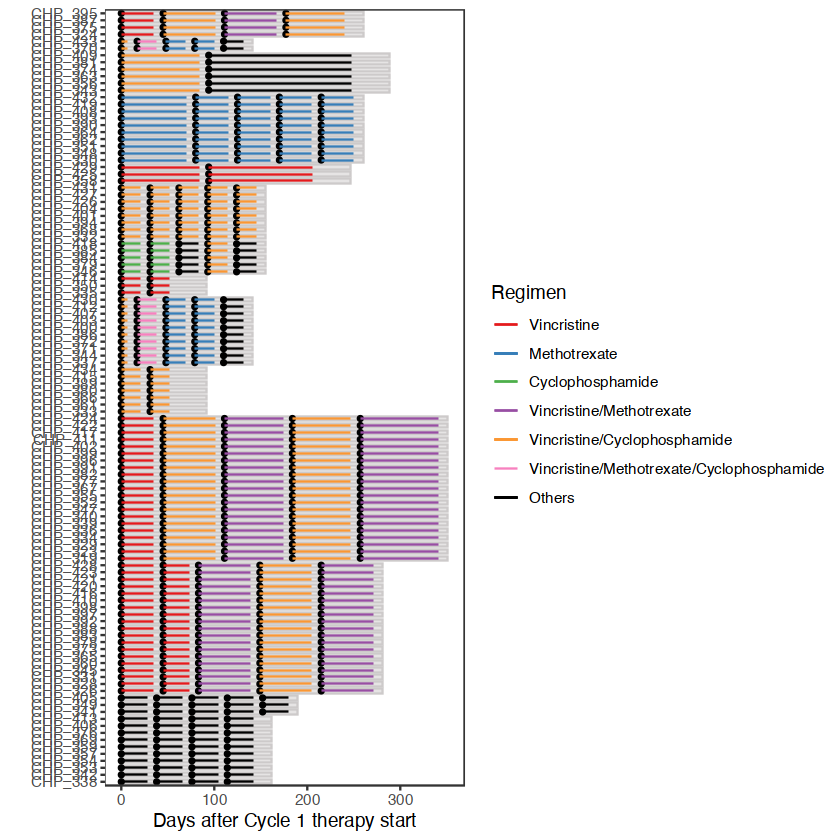

In [70]:
myp #+ scale_x_discrete(labels = drugs$Disease[match(drugs$Patient, drugs$Patient)]) 

In [71]:
pdf(paste0(plotpath, "swim_cancer_drugs.pdf"), width = 12, height = 12)
myp + scale_x_discrete(labels = drugs$Disease[match(drugs$Patient, drugs$Patient)]) 
dev.off()

Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 33 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 33 rows containing missing values or values outside the scale range
(`geom_segment()`)."


pdf 
  2